In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
from torch import optim


In [81]:
# Define transform (convert to tensor and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))  # mean and std of MNIST
])

# Download and load training dataset
train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)

# Download and load test dataset
test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

# Create dataloaders (optional)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# Verify one batch
images, labels = next(iter(train_loader))
print("Train batch shape:", images.shape)
print("Labels:", labels[:10])

Train batch shape: torch.Size([128, 1, 28, 28])
Labels: tensor([3, 2, 9, 8, 0, 3, 1, 9, 3, 4])


In [3]:
device = 'cuda'

In [4]:
class DownConvBlock(nn.Module):
    def __init__(self,c_in,c_out,kernel,stride,padding):
        super().__init__() 
        self.conv = nn.Sequential(
            nn.Conv2d(c_in,c_out,kernel,stride,padding,bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(),
        )
    def forward(self,x):
        return self.conv(x)

class UpConvBlock(nn.Module):
    def __init__(self,c_in,c_out,kernel,stride,padding,output_padding=0):
        super().__init__() 
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(c_in,c_out,kernel,stride,padding,output_padding,bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(),
        )
    def forward(self,x):
        return self.conv(x)

        

In [5]:
class Encode(nn.Module):
    def __init__(self,c_in,c_out,unit=[32,64,128]):
        super().__init__()
        self.layer1 = DownConvBlock(c_in,unit[0],kernel=3,stride=2,padding=1)
        self.layer2 = DownConvBlock(unit[0],unit[1],kernel=3,stride=2,padding=1)
        self.layer3 = DownConvBlock(unit[1],unit[2],kernel=3,stride=2,padding=1)
        self.flatten = nn.Sequential(
                nn.Flatten(),
                nn.Linear(unit[2] * 4 * 4, 512),
                nn.ReLU()
        )
        self.fc_mu     = nn.Linear(512, c_out)
        self.fc_logvar = nn.Linear(512, c_out)

    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x4 = self.layer4(x3)
        x = self.flatten(x)
        u = self.fc_mu(x)
        var = self.fc_logvar(x)
        
        return u, var

In [6]:
class Decode(nn.Module):
    def __init__(self, c_in, c_out, unit=[128,64,32]):
        super().__init__()
        self.prev =  nn.Sequential(
            nn.Linear(c_in, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * 4 * 4),
            nn.ReLU()
        )
        # 2 → 4 → 7 → 14 → 28
        self.up1 = UpConvBlock(unit[0], unit[1], kernel=3, stride=2, padding=1,)  # 2→4
        self.up2 = UpConvBlock(unit[1], unit[2], kernel=3, stride=2, padding=1, output_padding=1)  # 4→7
        # self.up3 = UpConvBlock(unit[2], c_out, kernel=3, stride=2, padding=1, output_padding=1)  # 7→14
        self.up3 = nn.Sequential(
                    nn.ConvTranspose2d(unit[2], c_out, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                    nn.BatchNorm2d(c_out),
                )
        # self.up4 = nn.ConvTranspose2d(unit[2], c_in, kernel_size=4, stride=2, padding=1)  # 14→28
        self.final = nn.Sigmoid()

    def forward(self, z):
        z = self.prev(z)
        z = z.view(-1, 128, 4, 4)
        z = self.up1(z)
        # print(z.shape)
        z = self.up2(z)
        # print(z.shape)
        z = self.up3(z)
        # print(z.shape)
        # z = self.up4(z)
        # print(z.shape)
        z = self.final(z)
        return z


In [7]:
class VAE(nn.Module):
    def __init__(self,c_in,latest_layer):
        super().__init__()
        self.encode = Encode(c_in,latest_layer)
        self.decode = Decode(latest_layer,c_in)

    def make_input(self,mu,var):
        std = torch.exp(0.5 * var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self,x):
        u, var = self.encode(x)
        x = self.make_input(u,var)
        x = self.decode(x)
        return x,u,var

In [8]:
### Loss Function I use BCE + KL_loss
def vae_loss_function(pred, y, mu, logvar):
    BCE = F.binary_cross_entropy(pred.view(-1, 28*28), y.view(-1, 28*28), reduction='sum')

    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total = BCE + kl_loss
    return total,kl_loss,BCE

## TEST Input Model

In [9]:
imgs, labels = next(iter(train_loader))
model = VAE(1,128).to(device)
model.eval()
with torch.no_grad():
    recons = model(imgs.to(device))
print(recons[0].shape)
print(recons[1].shape)
print(recons[2].shape)

torch.Size([128, 1, 28, 28])
torch.Size([128, 128])
torch.Size([128, 128])


## Train latent dimension 128 Unit with optimizer Adam + learning rate 1e-3

In [10]:
model = VAE(1,128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(1, 50 + 1):
    
    train_loss = 0
    BCE_loss = 0
    kl_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        # print(x.shape)
        out,u,var = model(x)
        loss,kl,mse = vae_loss_function(out,x,u,var)

        #### reset Prev gradient
        optimizer.zero_grad()
        #### Back Prop
        loss.backward()
        #### Update Weight
        optimizer.step() 
        
        train_loss += loss.item()
        BCE_loss += mse.item()
        kl_loss += kl.item()
    print(f"Epoch [{epoch}/{50}] Train Loss: {train_loss/len(train_loader.dataset):.4f} BCE Loss: {BCE_loss/len(train_loader.dataset):.4f} KL Loss: {kl_loss/len(train_loader.dataset):.4f}")
torch.save(model.state_dict(), "VAE_128.pth")


Epoch [1/50] Train Loss: 410.7860 BCE Loss: 402.0956 KL Loss: 8.6904
Epoch [2/50] Train Loss: 285.1402 BCE Loss: 267.9696 KL Loss: 17.1706
Epoch [3/50] Train Loss: 218.8351 BCE Loss: 199.9759 KL Loss: 18.8592
Epoch [4/50] Train Loss: 182.4158 BCE Loss: 162.6076 KL Loss: 19.8082
Epoch [5/50] Train Loss: 159.9265 BCE Loss: 139.7390 KL Loss: 20.1875
Epoch [6/50] Train Loss: 145.7445 BCE Loss: 125.1631 KL Loss: 20.5814
Epoch [7/50] Train Loss: 135.9295 BCE Loss: 115.1547 KL Loss: 20.7748
Epoch [8/50] Train Loss: 128.6868 BCE Loss: 107.7749 KL Loss: 20.9119
Epoch [9/50] Train Loss: 122.9252 BCE Loss: 101.9071 KL Loss: 21.0180
Epoch [10/50] Train Loss: 118.4002 BCE Loss: 97.2216 KL Loss: 21.1786
Epoch [11/50] Train Loss: 114.5696 BCE Loss: 93.3532 KL Loss: 21.2164
Epoch [12/50] Train Loss: 111.6538 BCE Loss: 90.3706 KL Loss: 21.2832
Epoch [13/50] Train Loss: 109.0909 BCE Loss: 87.7688 KL Loss: 21.3221
Epoch [14/50] Train Loss: 106.9969 BCE Loss: 85.6529 KL Loss: 21.3440
Epoch [15/50] Train L

## Train latent dimension 256 Unit with optimizer Adam + learning rate 1e-3

In [11]:
model = VAE(1,256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(1, 50 + 1):
    
    train_loss = 0
    BCE_loss = 0
    kl_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        # print(x.shape)
        out,u,var = model(x)
        loss,kl,mse = vae_loss_function(out,x,u,var)
        #### reset Prev gradient
        optimizer.zero_grad()
        #### Back Prop
        loss.backward()
        #### Update Weight
        optimizer.step()
        
        train_loss += loss.item()
        BCE_loss += mse.item()
        kl_loss += kl.item()
    print(f"Epoch [{epoch}/{50}] Train Loss: {train_loss/len(train_loader.dataset):.4f} BCE Loss: {BCE_loss/len(train_loader.dataset):.4f} KL Loss: {kl_loss/len(train_loader.dataset):.4f}")
torch.save(model.state_dict(), "VAE_256.pth")


Epoch [1/50] Train Loss: 416.8818 BCE Loss: 409.7754 KL Loss: 7.1064
Epoch [2/50] Train Loss: 297.2603 BCE Loss: 280.5644 KL Loss: 16.6959
Epoch [3/50] Train Loss: 231.1286 BCE Loss: 212.9862 KL Loss: 18.1424
Epoch [4/50] Train Loss: 190.0215 BCE Loss: 171.8639 KL Loss: 18.1576
Epoch [5/50] Train Loss: 165.7275 BCE Loss: 147.6816 KL Loss: 18.0459
Epoch [6/50] Train Loss: 149.9988 BCE Loss: 131.9524 KL Loss: 18.0464
Epoch [7/50] Train Loss: 139.8604 BCE Loss: 121.6675 KL Loss: 18.1929
Epoch [8/50] Train Loss: 132.5573 BCE Loss: 114.2516 KL Loss: 18.3057
Epoch [9/50] Train Loss: 126.8564 BCE Loss: 108.4708 KL Loss: 18.3856
Epoch [10/50] Train Loss: 122.3184 BCE Loss: 103.8968 KL Loss: 18.4216
Epoch [11/50] Train Loss: 118.7024 BCE Loss: 100.2196 KL Loss: 18.4827
Epoch [12/50] Train Loss: 115.3977 BCE Loss: 96.8108 KL Loss: 18.5870
Epoch [13/50] Train Loss: 112.6563 BCE Loss: 93.9535 KL Loss: 18.7028
Epoch [14/50] Train Loss: 110.3676 BCE Loss: 91.5771 KL Loss: 18.7904
Epoch [15/50] Train

In [60]:
model = VAE(1, 128).to(device)
model.load_state_dict(torch.load('VAE_128.pth', map_location=device))

<All keys matched successfully>

## Visualize reconstruction and latent space evolution.

In [82]:
import matplotlib.pyplot as plt

In [83]:
data, _ = next(iter(test_loader))
data = data.to(device)
model.eval()
with torch.no_grad():
    output, _, _ = model(data)

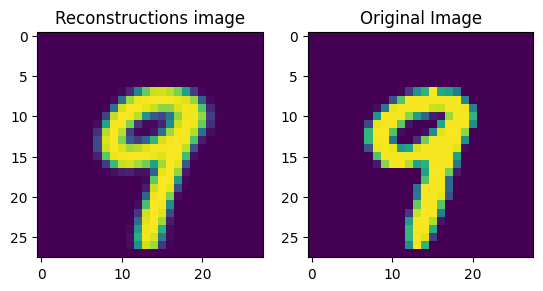

In [84]:
reconstructions = output.view(-1, 1, 28, 28).cpu().squeeze()
plt.subplot(1, 2, 1)
plt.title('Reconstructions image')
plt.imshow(reconstructions)
plt.subplot(1, 2,2)
plt.title('Original Image')
plt.imshow(data.cpu().squeeze())

 ## Generation and Visualization: Sample random z vectors → generate images.

In [85]:
model.eval()
with torch.no_grad():
    ### Random data z
    z = torch.randn(5, 128).to(device)
    generated_images = model.decode(z).cpu()
    

<Figure size 640x480 with 0 Axes>

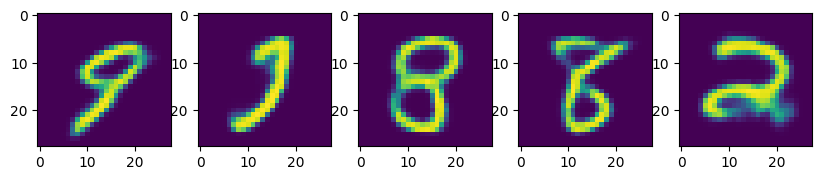

In [86]:
plt.suptitle('Generated Images', fontsize=16)
plt.figure(figsize=(10, 10))
plt.subplot(1, 5, 1)
plt.imshow(generated_images[0].squeeze())
plt.subplot(1, 5, 2)
plt.imshow(generated_images[1].squeeze())
plt.subplot(1, 5, 3)
plt.imshow(generated_images[2].squeeze())
plt.subplot(1, 5, 4)
plt.imshow(generated_images[3].squeeze())
plt.subplot(1, 5, 5)
plt.imshow(generated_images[4].squeeze())

## Interpolate between two z vectors to observe smooth transitions.

In [87]:
with torch.no_grad():
    data, _ = next(iter(test_loader))
    img1 = data.to(device)
    data, _ = next(iter(test_loader))
    img2 = data.to(device)

    mu1, _ = model.encode(img1)
    mu2, _ = model.encode(img2)

    z1 = mu1
    z2 = mu2

    alpha = torch.linspace(0, 1, 3).to(device)
    z_interp = []
    for a in alpha:
        z = (1.0 - a) * z1 + a * z2
        z_interp.append(z)
    z_interp = torch.cat(z_interp)
    interp_images = model.decode(z_interp).cpu()
    


<Figure size 640x480 with 0 Axes>

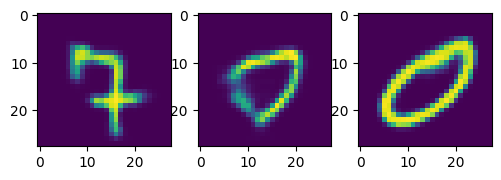

In [88]:
plt.suptitle('Generated Images', fontsize=16)
plt.figure(figsize=(10, 10))
plt.subplot(1, 5, 1)
plt.imshow(interp_images[0].squeeze())
plt.subplot(1, 5, 2)
plt.imshow(interp_images[1].squeeze())
plt.subplot(1, 5, 3)
plt.imshow(interp_images[2].squeeze())


## Visualize reconstruction and latent space evolution.

In [18]:
import matplotlib.pyplot as plt

In [89]:
model = VAE(1, 256).to(device)
model.load_state_dict(torch.load('VAE_256.pth', map_location=device))

<All keys matched successfully>

In [90]:
data, _ = next(iter(test_loader))
data = data.to(device)
model.eval()
with torch.no_grad():
    output, _, _ = model(data)

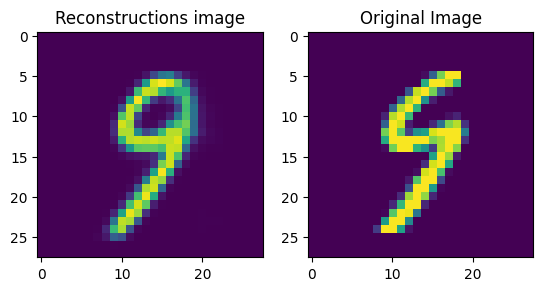

In [91]:
reconstructions = output.view(-1, 1, 28, 28).cpu().squeeze()
plt.subplot(1, 2, 1)
plt.title('Reconstructions image')
plt.imshow(reconstructions)
plt.subplot(1, 2,2)
plt.title('Original Image')
plt.imshow(data.cpu().squeeze())

 ## Generation and Visualization: Sample random z vectors → generate images.

In [92]:
model.eval()
with torch.no_grad():
    ### Random data z
    z = torch.randn(5, 256).to(device)
    generated_images = model.decode(z).cpu()
    

<Figure size 640x480 with 0 Axes>

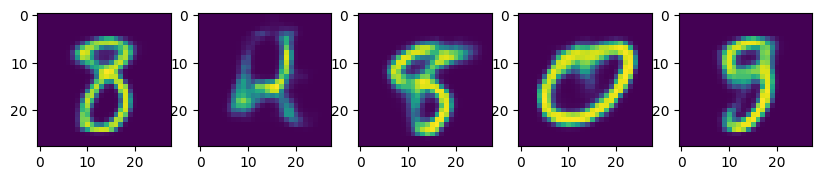

In [93]:
plt.suptitle('Generated Images', fontsize=16)
plt.figure(figsize=(10, 10))
plt.subplot(1, 5, 1)
plt.imshow(generated_images[0].squeeze())
plt.subplot(1, 5, 2)
plt.imshow(generated_images[1].squeeze())
plt.subplot(1, 5, 3)
plt.imshow(generated_images[2].squeeze())
plt.subplot(1, 5, 4)
plt.imshow(generated_images[3].squeeze())
plt.subplot(1, 5, 5)
plt.imshow(generated_images[4].squeeze())

## Interpolate between two z vectors to observe smooth transitions.

In [94]:
with torch.no_grad():
    data, _ = next(iter(test_loader))
    img1 = data.to(device)
    data, _ = next(iter(test_loader))
    img2 = data.to(device)

    mu1, _ = model.encode(img1)
    mu2, _ = model.encode(img2)

    z1 = mu1
    z2 = mu2

    alpha = torch.linspace(0, 1, 3).to(device)
    z_interp = []
    for a in alpha:
        z = (1.0 - a) * z1 + a * z2
        z_interp.append(z)
    z_interp = torch.cat(z_interp)
    interp_images = model.decode(z_interp).cpu()
    


<Figure size 640x480 with 0 Axes>

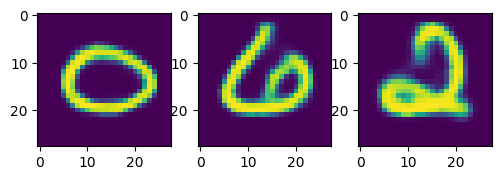

In [95]:
plt.suptitle('Generated Images', fontsize=16)
plt.figure(figsize=(10, 10))
plt.subplot(1, 5, 1)
plt.imshow(interp_images[0].squeeze())
plt.subplot(1, 5, 2)
plt.imshow(interp_images[1].squeeze())
plt.subplot(1, 5, 3)
plt.imshow(interp_images[2].squeeze())
